In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp

In [2]:
def plot_path(fig,cart_path,xlim=[-5,5],ylim=[-5,5],color='red',scatter=0):
    path = cart_path
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
    if(scatter==1):
        fig.scatter(path[:,0],path[:,1],c=color,edgecolors='black',s=40,marker="o",label='input')
        # num_step = len(target)
        # plt.scatter(path[num_step-1,0],path[num_step-1,1],c="yellow",s=500,marker="*")
    else:
        x = path[0:len(path)-1,0]
        y = path[0:len(path)-1,1]
        u = path[1:len(path),0] - x
        v = path[1:len(path),1] - y
        fig.quiver(x,y,u,v, scale_units='xy', angles='xy', scale=1,color=color, width=0.003)
    fig.set_xlabel("x[m]")
    fig.set_ylabel("y[m]")
    fig.axis('scaled')
    fig.set_xlim(xlim[0],xlim[1])
    fig.set_ylim(ylim[0],ylim[1])
    fig.grid()
    return fig

In [3]:
# loss
def error_squares(z_oplus,z_true):
    #print(predict)
    #print(groundtruth)
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

def error_diff_v(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def error_diff_w(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def error_limit_rotate_vel(predict,limit):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data < limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def error_limit_trans_vel(predict,limit):
    w = xp.array([1., 0., 0.],dtype=xp.float32)
    p = predict * w
    vel = F.sum(F.absolute(p))
    if vel.data <= limit:
        error = vel * .0
    else:
        error = (vel - limit) / limit
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

def loss_function(y, y_true,dmesg=0):
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_STEP):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    # limit v
    e_lim_v = error_limit_trans_vel(y[0,0], DATA_M_PER_STEP)
    for i in range(1,DATA_NUM_STEP):
        e_lim_v = e_lim_v + error_limit_trans_vel(y[0,i], DATA_M_PER_STEP)        
    # limit w
    e_lim_w = error_limit_rotate_vel(y[0,0], DATA_RAD_PER_STEP)
    for i in range(1,DATA_NUM_STEP):
        e_lim_w = e_lim_w + error_limit_rotate_vel(y[0,i] , DATA_RAD_PER_STEP)
    loss = (1 * e_distance) #  + (1 * e_lim_w) + (1 * e_lim_v)
    if(dmesg):
        print('e_distance: ' + str(e_distance)) # + '\t e_lim_w: '  + str(e_lim_w) + '\t e_lim_v: '  + str(e_lim_v))
    return loss

In [4]:
# dataset
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_HZ = 30
DATA_MAX_TRANS_VEL = 1.0 # [m/s]
DATA_MAX_ROTATE_VEL = 2*xp.pi # [rad/s]
DATA_M_PER_STEP = DATA_MAX_TRANS_VEL / DATA_HZ # [m/step]
DATA_RAD_PER_STEP = DATA_MAX_ROTATE_VEL / DATA_HZ # [rad/step]

print('DATA_NUM_WAYPOINTS :',DATA_NUM_WAYPOINTS)
print('DATA_NUM_STEP      :',DATA_NUM_STEP)
print('DATA_HZ            :',DATA_HZ) 
print('DATA_MAX_TRANS_VEL :',DATA_MAX_TRANS_VEL)
print('DATA_MAX_ROTATE_VEL:',DATA_MAX_ROTATE_VEL)
print('DATA_M_PER_STEP    :',DATA_M_PER_STEP)
print('DATA_RAD_PER_STEP  :', DATA_RAD_PER_STEP)

DATA_NUM_WAYPOINTS : 10
DATA_NUM_STEP      : 10
DATA_HZ            : 30
DATA_MAX_TRANS_VEL : 1.0
DATA_MAX_ROTATE_VEL: 6.283185307179586
DATA_M_PER_STEP    : 0.03333333333333333
DATA_RAD_PER_STEP  : 0.20943951023931953


In [5]:
'''
modelname = [
    'old_npz/Cart50mm10step_20190820155112_1000data100epoch/Cart50mm10step_20190820155112_1000data100epoch.model',
    'Cart50mm10step_20190827191724_1000data100epoch/Cart50mm10step_20190827191724_1000data100epoch.model',
    'Cart50mm10step_20190915175330_1000data100epoch/Cart50mm10step_20190915175330_1000data100epoch.model',
    'Cart50mm10step_20190916204453_1000data100epoch/Cart50mm10step_20190916204453_1000data100epoch.model',
    'Cart50mm10step_20190917125759_1000data100epoch/Cart50mm10step_20190917125759_1000data100epoch.model',
    'Cart50mm10step_20190917155346_1000data100epoch/Cart50mm10step_20190917155346_1000data100epoch.model'
]
modelname = [
    'Cart33mm10step_201909201922_1000data100ep/Cart33mm10step_201909201922_1000data100ep.model',
    'Cart33mm10step_201909211546_1000data100ep/Cart33mm10step_201909211546_1000data100ep.model'
]
'''
modelname = [
    'Cart30mm10step_201909211944_1000data100ep/Cart30mm10step_201909211944_1000data100ep.model',
    'Cart30mm10step_201909241518_1000data100ep/Cart30mm10step_201909241518_1000data100ep.model',
    'Cart30mm10step_201909241812_1000data100ep/Cart30mm10step_201909241812_1000data100ep.model',
    'Cart30mm10step_201909241921_1000data100ep/Cart30mm10step_201909241921_1000data100ep.model'
]

modelcolors = [
    'blue',
    'green',
    'yellowgreen',
    'purple',
    'magenta',
    'hotpink'
]
models = [Generator(DATA_NUM_WAYPOINTS,DATA_NUM_STEP) for i in range(len(modelname))]
for i in range(len(models)):
    serializers.load_npz(modelname[i],models[i])
    if settings.gpu_index >= 0:
        cuda.cupy.cuda.Device(settings.gpu_index).use()
        models[i].to_gpu(settings.gpu_index)

In [6]:
def predict(model,x):
    y = model(x)
    pad = Variable(xp.zeros((1,DATA_NUM_WAYPOINTS,1),dtype=xp.float32))
    y_pad = F.concat((y,pad),axis=2)
    y_pad = F.permutate(y_pad, xp.array([0,2,1],'i'), axis=2)
    loss = loss_function(y_pad, x_test)
    z_oplus = xp.array([x.data for x in calc_oplus(y_pad)],dtype=xp.float32)
    return y, loss, z_oplus

input_A = -0.20943951023931953 rad/step
input_B = -0.17951958020513104 rad/step
input_C = -0.1495996501709425 rad/step
input_D = -0.11967972013675401 rad/step
input_E = -0.08975979010256552 rad/step
input_F = -0.059839860068377014 rad/step
input_G = -0.02991993003418851 rad/step
input_H = -6.938893903907228e-18 rad/step
input_I = 0.029919930034188497 rad/step
input_J = 0.059839860068377 rad/step
input_K = 0.0897597901025655 rad/step
input_L = 0.11967972013675401 rad/step
input_M = 0.1495996501709425 rad/step
input_N = 0.179519580205131 rad/step
input_O = 0.20943951023931953 rad/step
model_A = Cart30mm10step_201909211944_1000data100ep/Cart30mm10step_201909211944_1000data100ep.model
model_B = Cart30mm10step_201909241518_1000data100ep/Cart30mm10step_201909241518_1000data100ep.model
model_C = Cart30mm10step_201909241812_1000data100ep/Cart30mm10step_201909241812_1000data100ep.model
model_D = Cart30mm10step_201909241921_1000data100ep/Cart30mm10step_201909241921_1000data100ep.model
 --- 


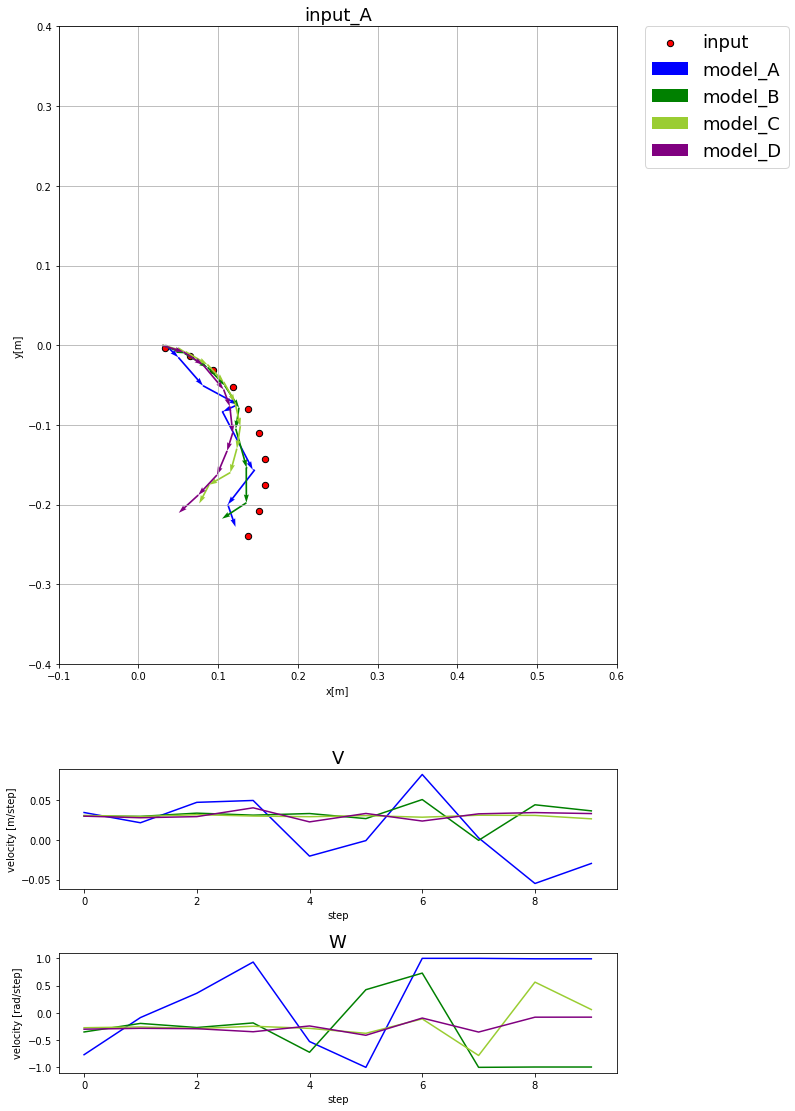

 --- 


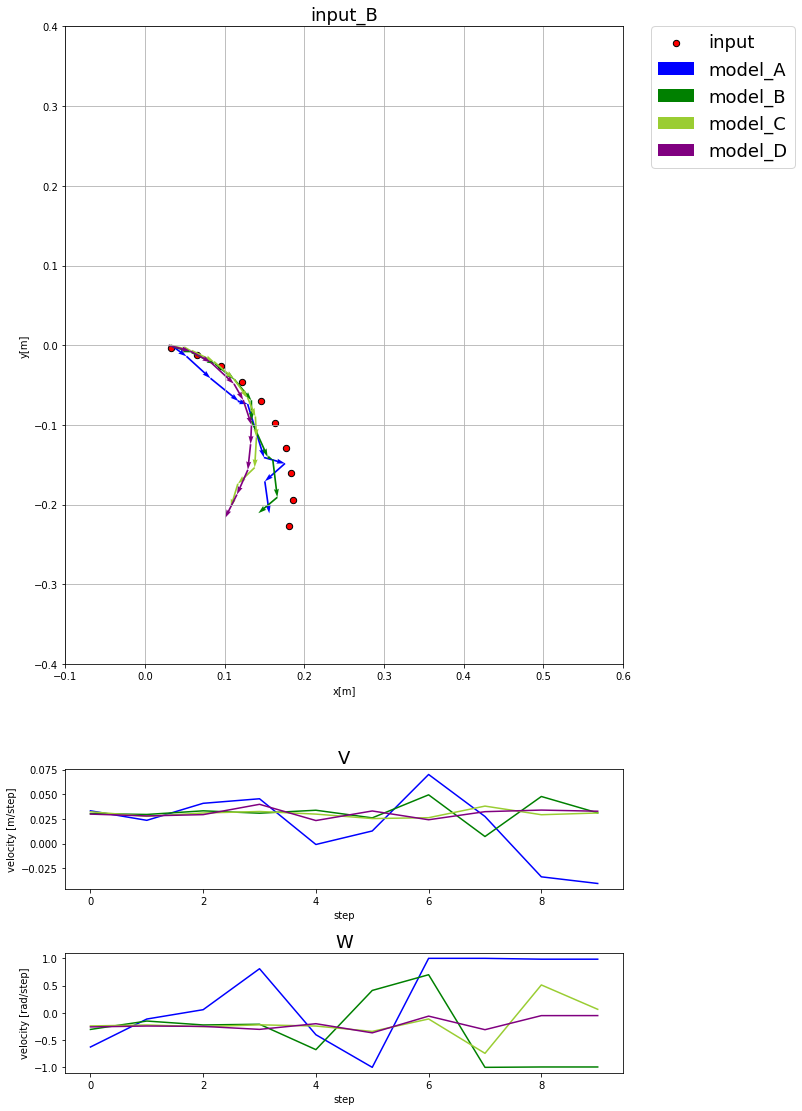

 --- 


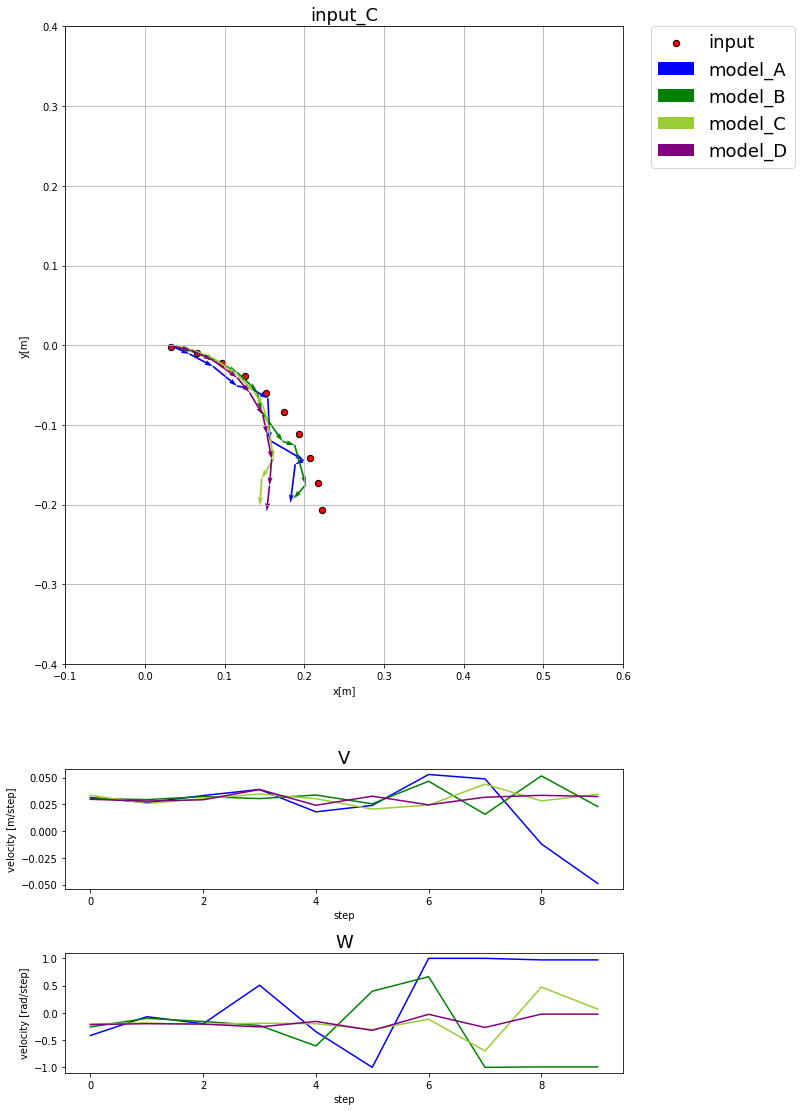

 --- 


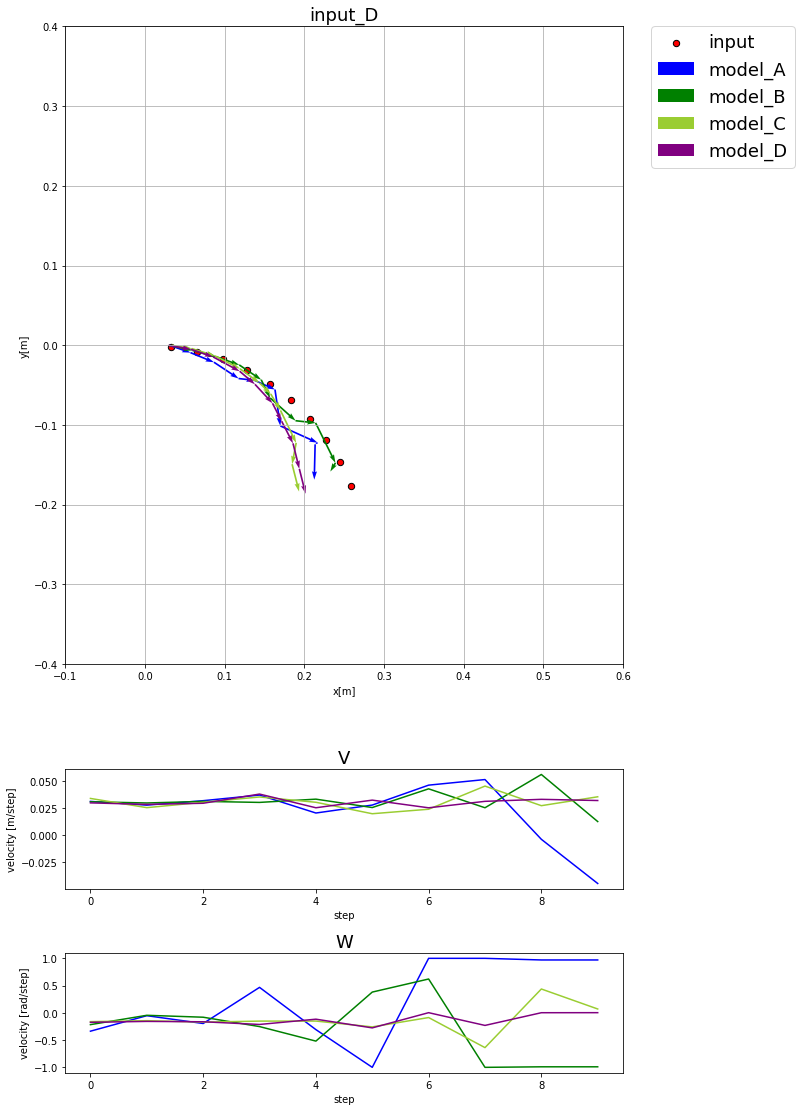

 --- 


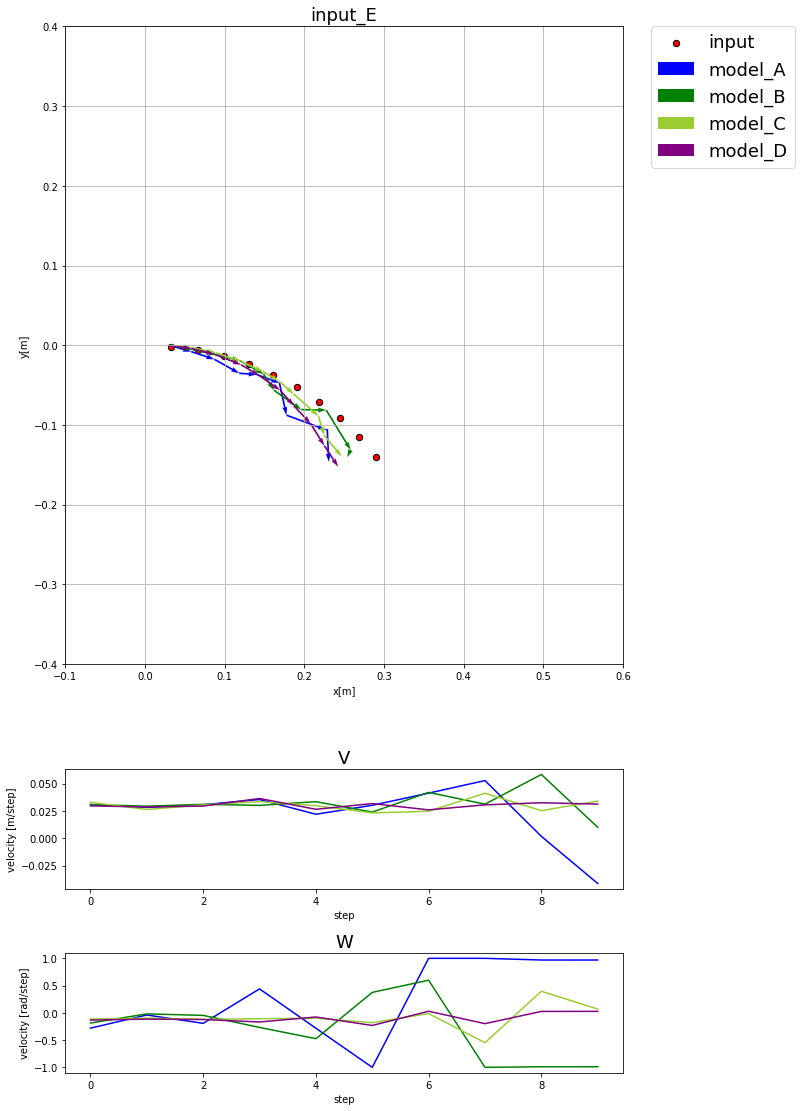

 --- 


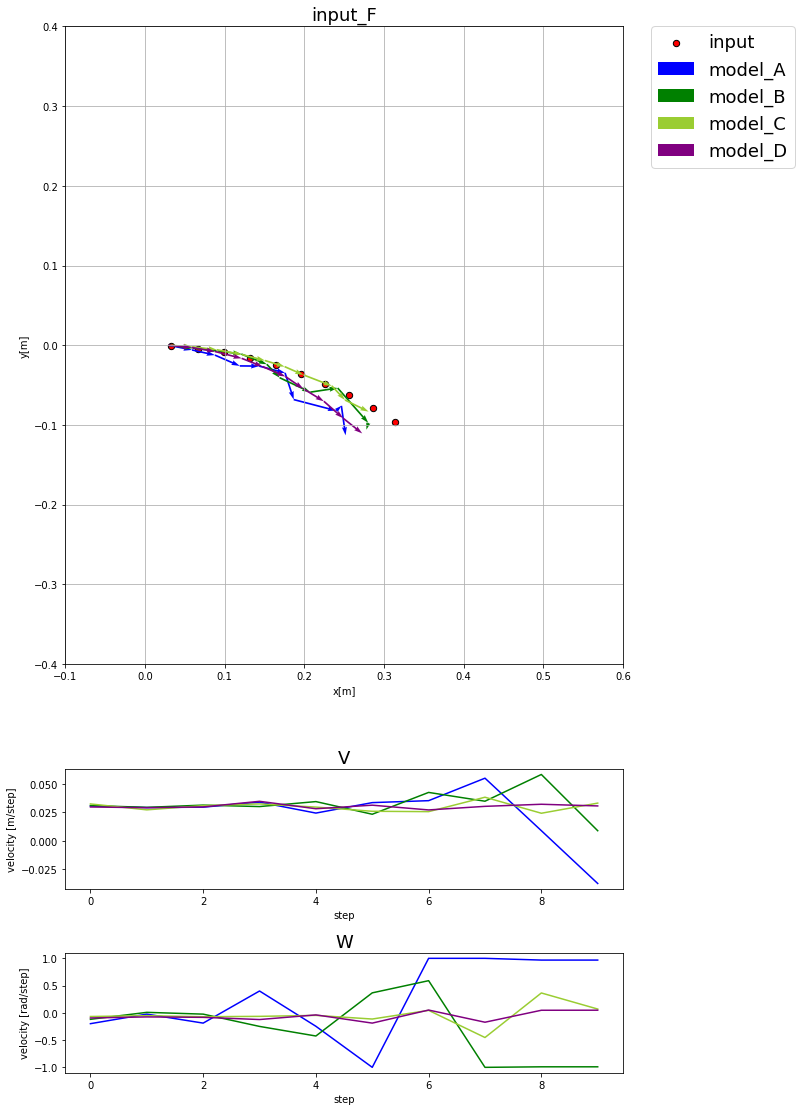

 --- 


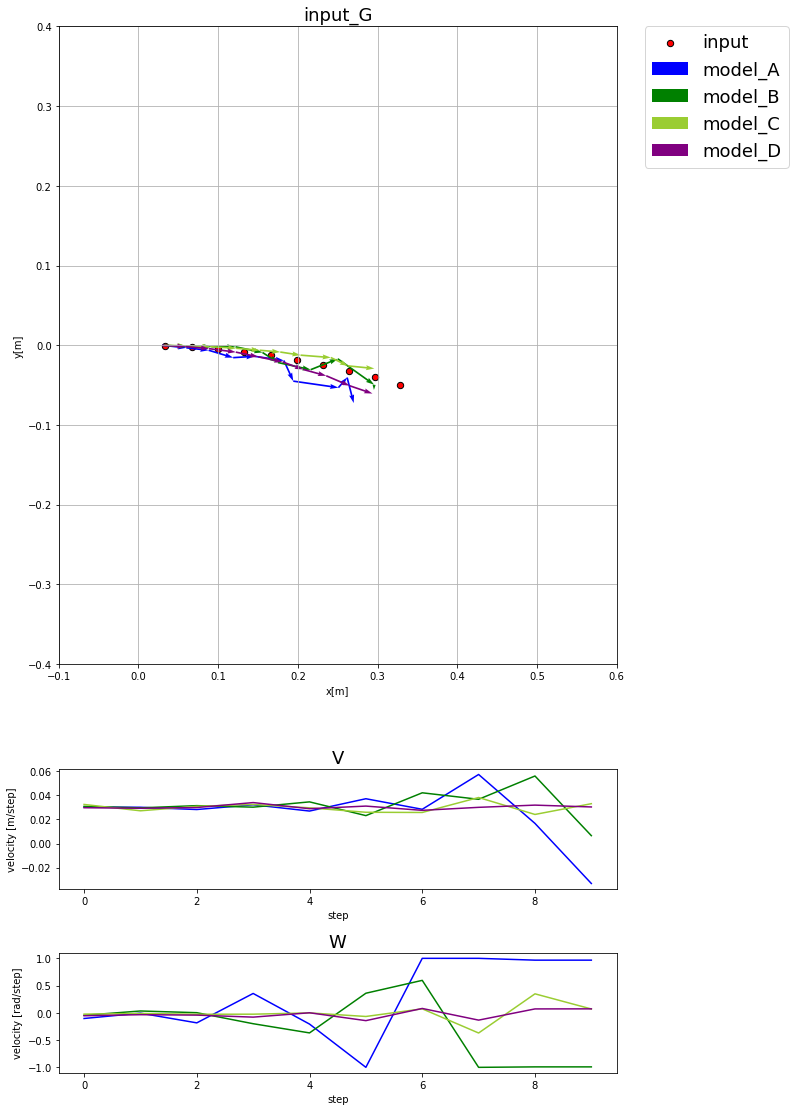

 --- 


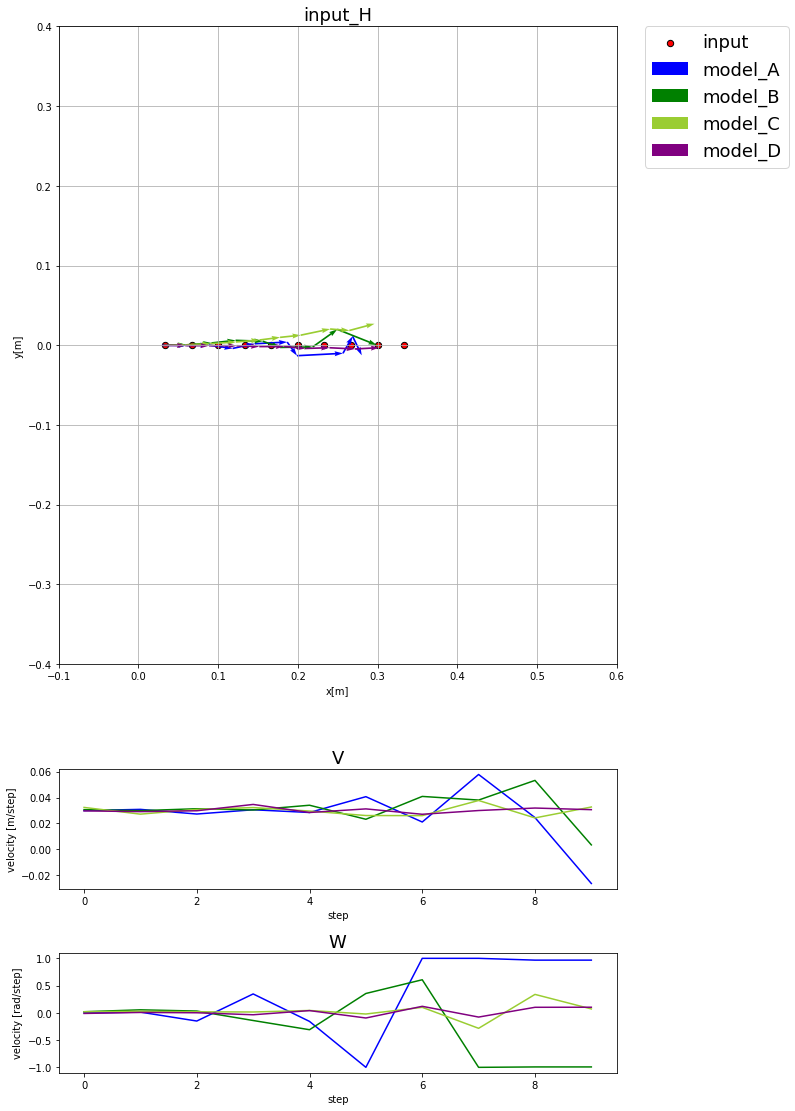

 --- 


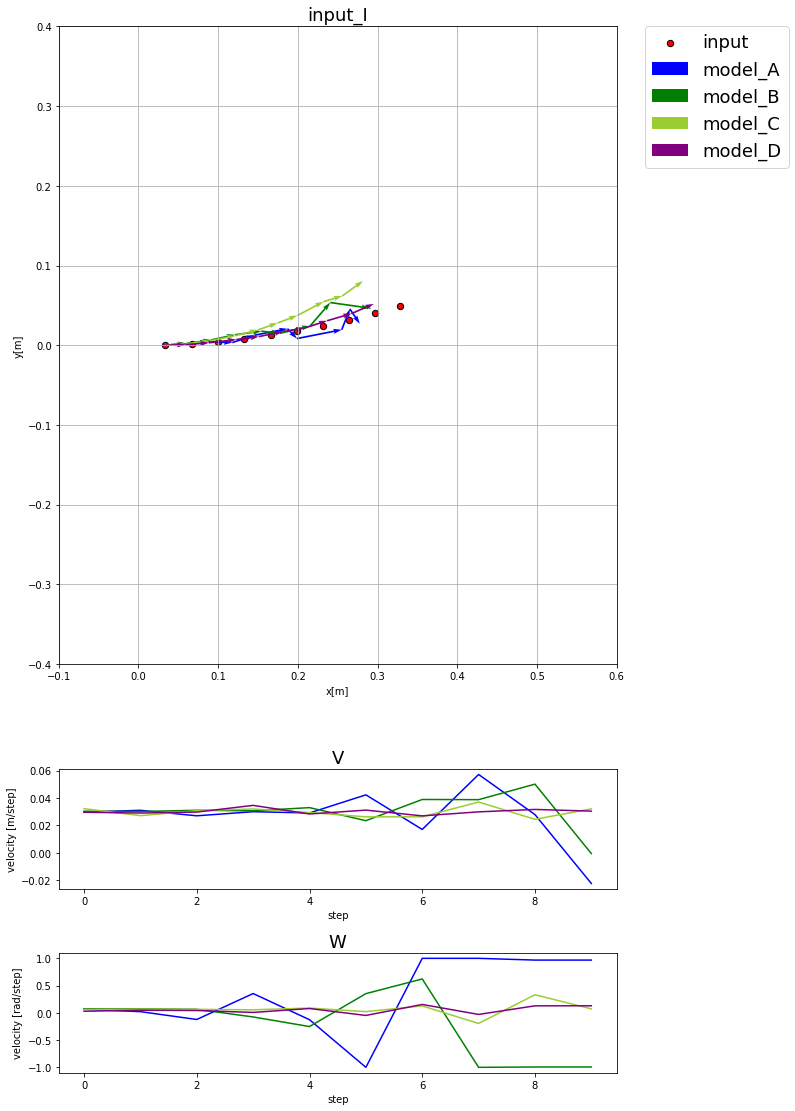

 --- 


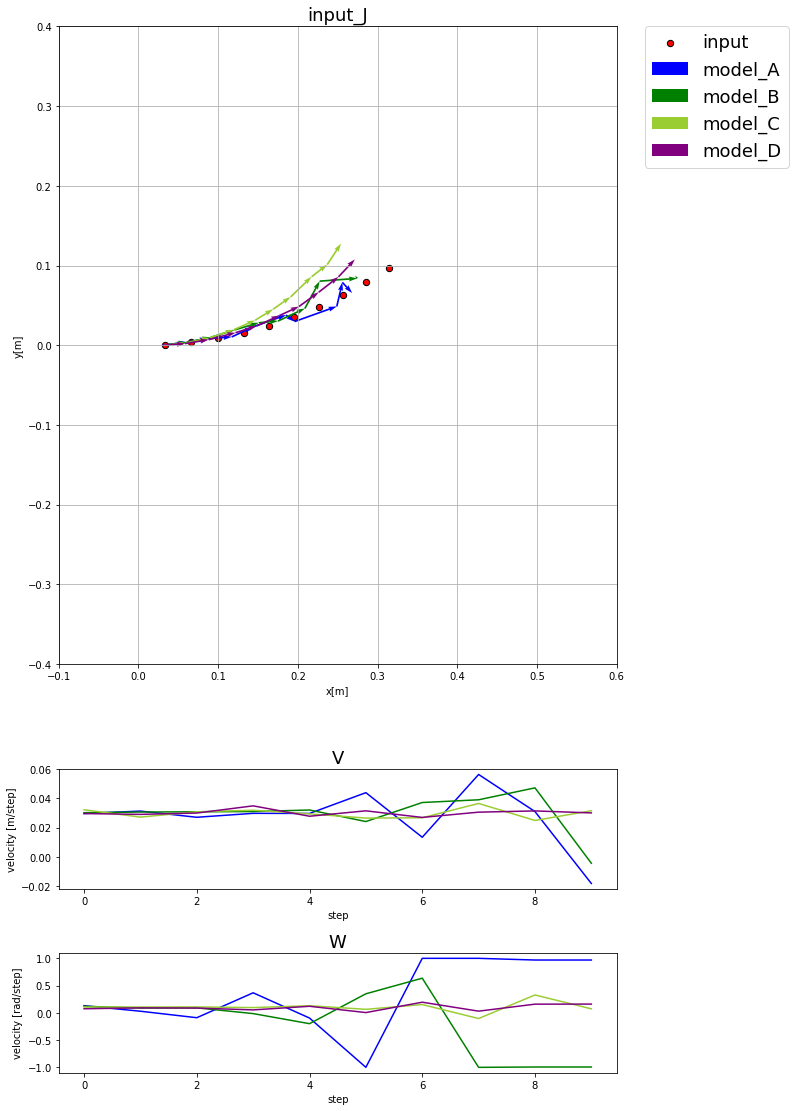

 --- 


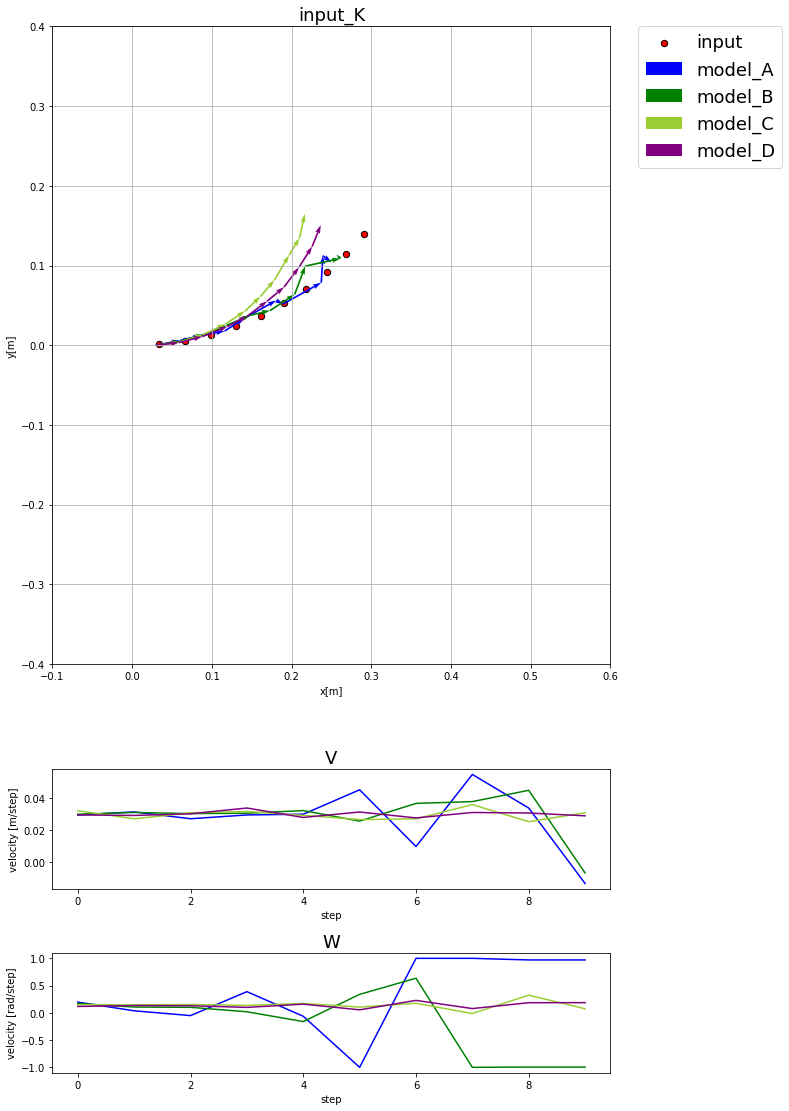

 --- 


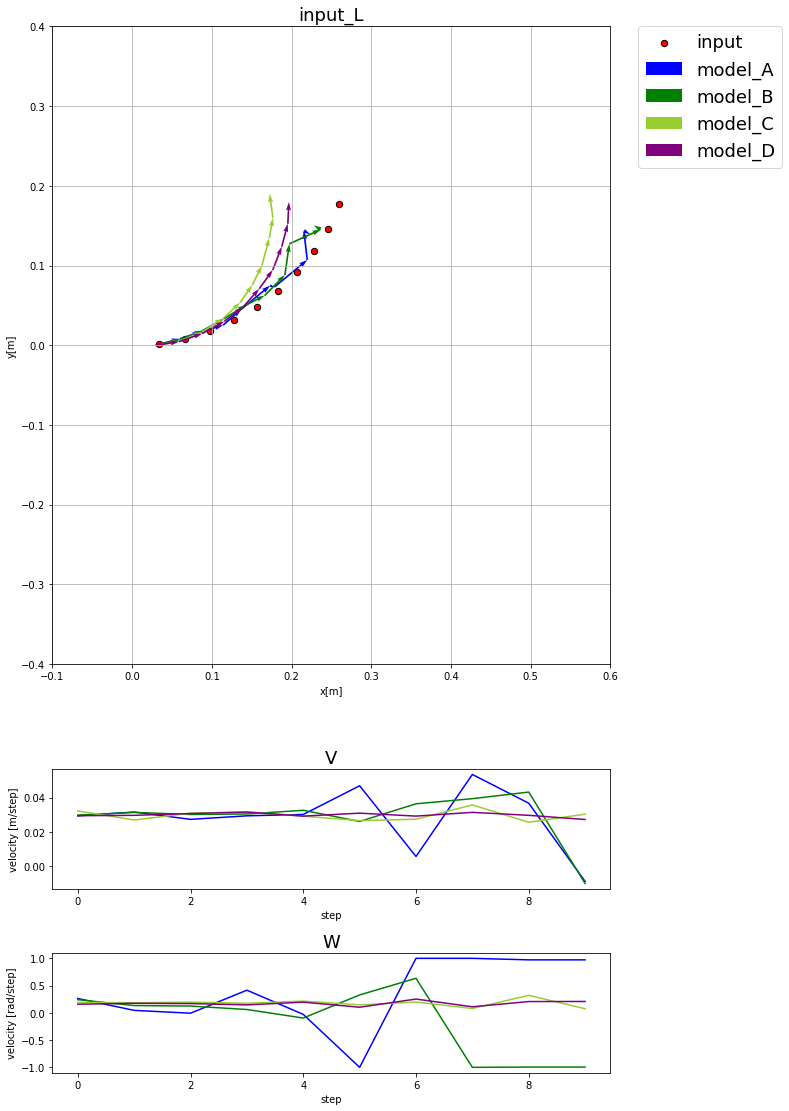

 --- 


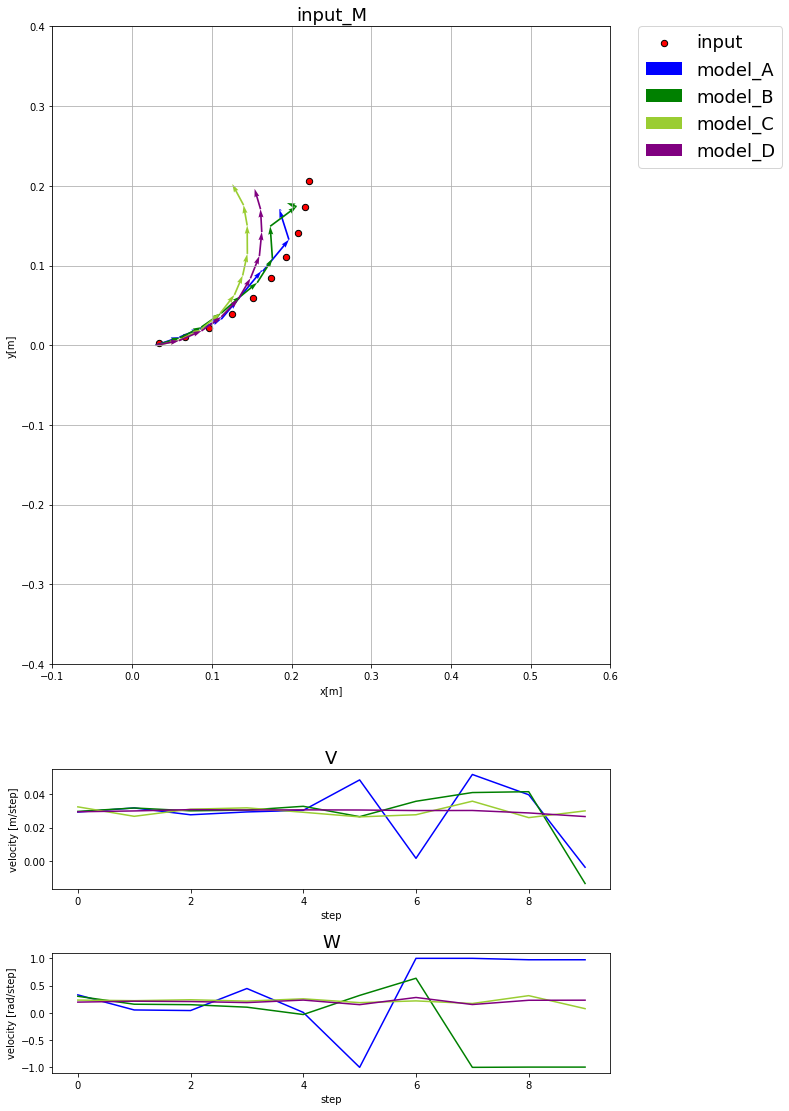

 --- 


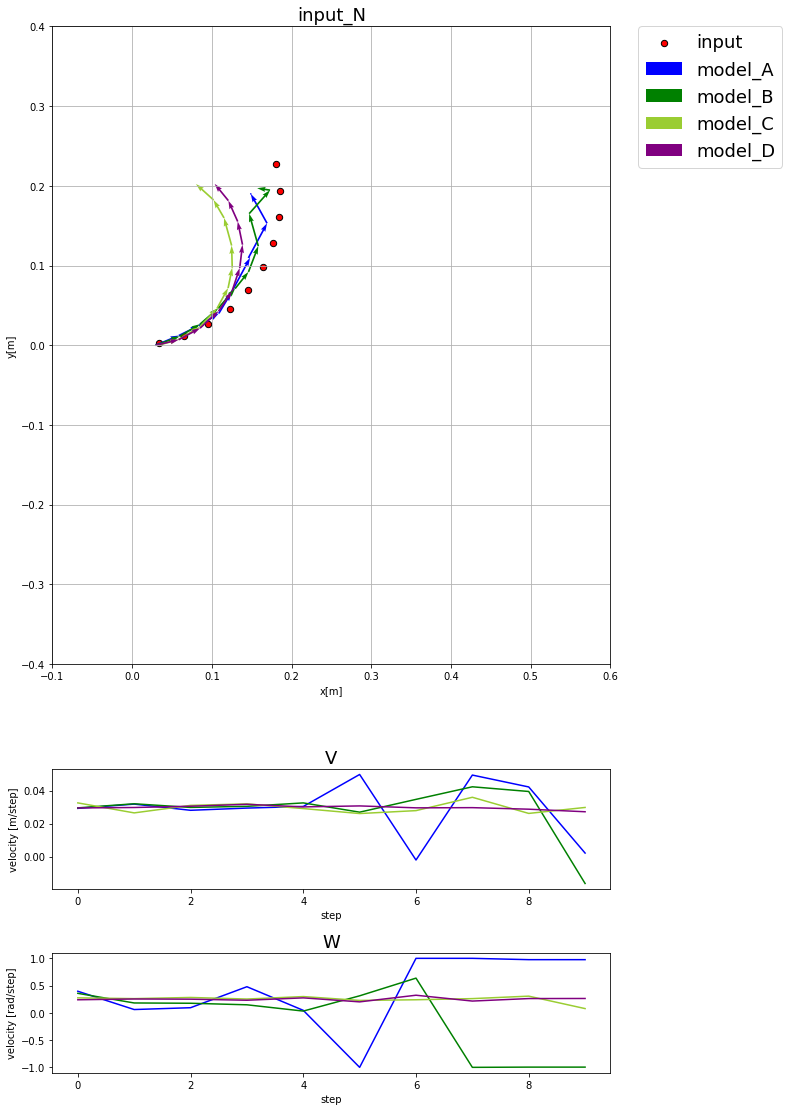

 --- 


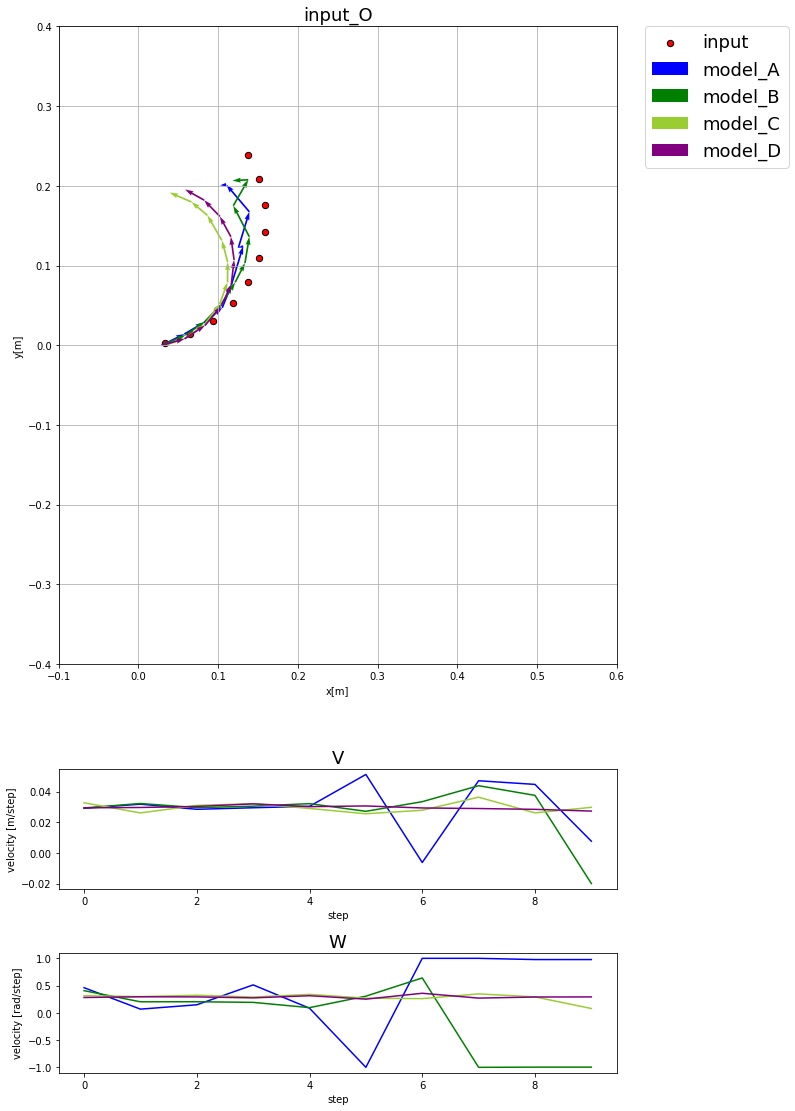

In [7]:
#rad = xp.linspace(-DATA_RAD_PER_STEP, DATA_RAD_PER_STEP, 73) # -36 ~ 36 m/step
#rad = xp.linspace(-xp.deg2rad(5),xp.deg2rad(5), 15)
rad = xp.linspace(-DATA_RAD_PER_STEP, DATA_RAD_PER_STEP, 15) # -36 ~ 36 m/step
panels = ['loss','v_1','w_1' ,'average_v','average_w']
columns = ['model_'+chr(ord('A')+x) for x in range(len(modelname))]
#columns = [x.split('/')[0] for x in modelname]
rows = [float(x) for x in rad]
rows_name = ['input_'+chr(ord('A')+x) for x in range(len(rad))]
for i in range(len(rows)):
    print(str(rows_name[i])+' = '+ str(rows[i])+' rad/step')
for i in range(len(modelname)):
    print(columns[i]+ ' = '+modelname[i])

loss_df = pd.DataFrame(index=rows, columns=columns)
v_1_df = pd.DataFrame(index=rows, columns=columns)
w_1_df = pd.DataFrame(index=rows, columns=columns)
ave_v_df = pd.DataFrame(index=rows, columns=columns)
ave_w_df = pd.DataFrame(index=rows, columns=columns)
for i in range(len(rad)):
    print(' --- ')
    Y = []
    fig ,axes = plt.subplots(3,1, gridspec_kw={'height_ratios': [6,1,1]},figsize=(10,20))
    plt.subplots_adjust(wspace=0, hspace=0.2)
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(1,1,1)
    x_test = data.generate_arc_path(DATA_NUM_STEP,rad[i],DATA_M_PER_STEP)
    x = xp.ravel(x_test[:,0:2])
    x = Variable(xp.array([x],dtype=xp.float32))
    axes[0] = plot_path(axes[0],x_test,xlim=[-.1,.6],ylim=[-.4,.4],scatter=1)
    for j in range(len(models)):
        y, loss, z_oplus = predict(models[j],x)
        Y.append(y.data)
        mean_v = xp.mean(y.data[0,:,0])
        mean_w = xp.mean(y.data[0,:,1])
        loss_df.iat[i,j] = loss.data
        ave_v_df.iat[i,j] = mean_v
        ave_w_df.iat[i,j] = mean_w
        v_1_df.iat[i,j] = y.data[0,0,0]
        w_1_df.iat[i,j] = y.data[0,0,1]
        axes[0] = plot_path(axes[0], z_oplus,xlim=[-.1,.6],ylim=[-.4,.4],color=modelcolors[j])
        if(settings.gpu_index >= 0):
            y_np = xp.asnumpy(y.data)
        margin = 0.05
        axes[1].plot(y_np[0,:,0],color=modelcolors[j])
        #axes[1].set_ylim([0,DATA_M_PER_STEP+margin])
        axes[1].set_title('V', fontsize=18)
        axes[1].set_ylabel('velocity [m/step]')
        axes[1].set_xlabel('step')
        axes[1].grid()
        margin = 0.5
        axes[2].plot(y_np[0,:,1],color=modelcolors[j])
        #axes[2].set_ylim([-DATA_RAD_PER_STEP-margin,DATA_RAD_PER_STEP+margin])
        axes[2].set_ylabel('velocity [rad/step]')
        axes[2].set_xlabel('step')
        axes[2].set_title('W', fontsize=18)
        axes[2].grid()
    leg = columns.copy()
    leg.insert(0,'input')
    axes[0].legend(leg,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    #axes[0].grid()
    axes[0].set_title(rows_name[i], fontsize=18)
    plt.show()

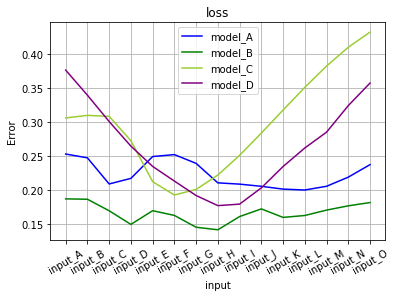

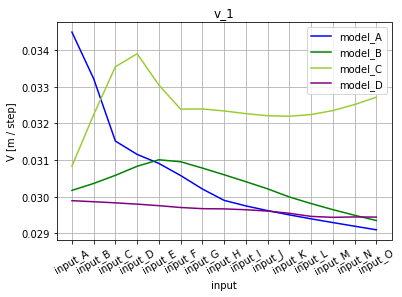

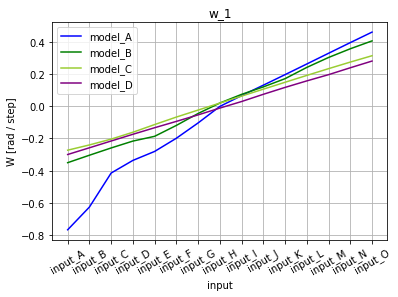

"\n# print(v_df)\nave_v_df.plot(title='average v')\nplt.xticks(rows,rows_name,rotation=30)\nplt.ylabel('v [m / step]')\nplt.xlabel('input')\nplt.grid()\nplt.show()\n# print(v_df)\nave_w_df.plot(title='average ω')\nplt.xticks(rows,rows_name,rotation=30)\nplt.ylabel('loss')\nplt.ylabel('ω [rad / step]')\nplt.xlabel('input')\nplt.grid()\nplt.show()\n# print(w_df)\n"

In [8]:
loss_df = loss_df.astype(float)
ave_v_df = ave_v_df.astype(float)
ave_w_df = ave_w_df.astype(float)
v_1_df = v_1_df.astype(float)
w_1_df = w_1_df.astype(float)

loss_df.plot(title='loss',color=modelcolors)
plt.xticks(rows,rows_name,rotation=30)
plt.ylabel('Error')
plt.xlabel('input')
plt.grid()
plt.show()
# print(loss_df)
v_1_df.plot(title='v_1',color=modelcolors)
plt.xticks(rows,rows_name,rotation=30)
margin = 0.01
#plt.ylim([0,DATA_M_PER_STEP+margin])
plt.ylabel('V [m / step]')
plt.xlabel('input')
plt.grid()
plt.show()
# print(v_df)
w_1_df.plot(title='w_1',color=modelcolors)
plt.xticks(rows,rows_name,rotation=30)
margin = 0
#plt.ylim([-DATA_RAD_PER_STEP-margin,DATA_RAD_PER_STEP+margin])
plt.ylabel('W [rad / step]')
plt.xlabel('input')
plt.grid()
plt.show()
'''
# print(v_df)
ave_v_df.plot(title='average v')
plt.xticks(rows,rows_name,rotation=30)
plt.ylabel('v [m / step]')
plt.xlabel('input')
plt.grid()
plt.show()
# print(v_df)
ave_w_df.plot(title='average ω')
plt.xticks(rows,rows_name,rotation=30)
plt.ylabel('loss')
plt.ylabel('ω [rad / step]')
plt.xlabel('input')
plt.grid()
plt.show()
# print(w_df)
'''

In [9]:
print('loss')
print(loss_df)
print('\nv_1')
print(v_1_df)
print('\nw_1')
print(w_1_df)
'''
print('\naverage v')
print(ave_v_df)
print('\naverage w')
print(ave_w_df)
'''

loss
                model_A   model_B   model_C   model_D
-2.094395e-01  0.253106  0.187064  0.306233  0.376649
-1.795196e-01  0.247479  0.186532  0.309995  0.339745
-1.495997e-01  0.209017  0.169554  0.308603  0.300944
-1.196797e-01  0.217249  0.149485  0.272729  0.264761
-8.975979e-02  0.249388  0.169654  0.212395  0.234884
-5.983986e-02  0.252232  0.162717  0.192803  0.213295
-2.991993e-02  0.239344  0.145296  0.200947  0.192019
-6.938894e-18  0.210644  0.141564  0.222169  0.177151
 2.991993e-02  0.208776  0.161015  0.251163  0.179341
 5.983986e-02  0.205558  0.172305  0.283890  0.203230
 8.975979e-02  0.201445  0.159786  0.317829  0.234703
 1.196797e-01  0.200135  0.162607  0.351242  0.262008
 1.495997e-01  0.205604  0.170525  0.382588  0.285265
 1.795196e-01  0.219060  0.176841  0.410266  0.324361
 2.094395e-01  0.237488  0.181646  0.432583  0.357606

v_1
                model_A   model_B   model_C   model_D
-2.094395e-01  0.034489  0.030174  0.030834  0.029893
-1.795196e-01  0.0

"\nprint('\naverage v')\nprint(ave_v_df)\nprint('\naverage w')\nprint(ave_w_df)\n"